# Do NPDES enforcement patterns change after TMDLs?

Author: Ryan Treves

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import seaborn as sns
from datetime import timedelta
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data_path = 'data/'

# Load ATTAINS data
tmdls = pd.read_csv(data_path + 'all_actions.csv', parse_dates=['completionDate', 'TMDLDate'],
                    date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).rename(
    columns={'assessmentUnitIdentifier': 'AUID'})
tmdl_permit_links = pd.read_csv(data_path + 'all_actions_permit_data.csv').rename(columns={'NPDESIdentifier': 'npdes_permit_id'})

# Load RAD Data
# HUC AUID link table (source: `get_huc_AUID_links.R`)
HUC_AUID_links = pd.read_csv(data_path + 'huc_AUID_links.csv', dtype={'attributes.huc12': object})
HUC_AUID_links = HUC_AUID_links.drop('Unnamed: 0', axis=1).rename(
    columns={'attributes.huc12': 'HUC-12', 'attributes.assessmentunitidentifier': 'AUID'})
# HUC NPDES permit link table (source: `get_huc_npdes_permit_links.R`)
HUC_npdes_permit_links = pd.read_csv(data_path + 'huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object})
HUC_npdes_permit_links = HUC_npdes_permit_links.drop('Unnamed: 0', axis=1).rename(
    columns={'attributes.WBD_HUC12': 'HUC-12'})
huc_AUID_links = pd.read_csv(data_path + 'huc_AUID_links.csv', dtype={'attributes.huc12': object}).rename(
    columns={'attributes.assessmentunitidentifier': 'AUID', 'attributes.huc12': 'HUC-12'})

In [3]:
# Filter out TMDLs categorized as exclusively Nonpoint source
tmdls = tmdls[tmdls['pollutantSourceTypeCode'] != 'Nonpoint source']

# Link TMDLs to HUC-12 codes to NPDES permittees. This is our 'geospatial' linkage.
tmdls_merged = tmdls.drop_duplicates().merge(HUC_AUID_links, on='AUID', how='inner').merge(HUC_npdes_permit_links,
                                                                                           on='HUC-12', how='inner')
# Because the geospatial linkage may not catch all NPDES permittees linked to TMDLs, let's take the union of the geospatial links
# and the tabular links (based on NPDES permittees explicitly mentioned in ATTAINS TMDL records):
tmdls_merged = tmdls_merged.merge(tmdl_permit_links, on=['actionIdentifier', 'npdes_permit_id'], how='outer')

# Deleting objects we no longer need to save memory
del HUC_AUID_links
del HUC_npdes_permit_links

In [4]:
# NPDES enforcement data
npdes_enforcement_actions = pd.read_csv(data_path + 'npdes_enforcement_actions.csv', parse_dates=['enforcement_action_date'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'))

# Merge on TMDL and NPDES data
tmdls_enforcements_merged = tmdls_merged.merge(npdes_enforcement_actions, on='npdes_permit_id', how='left')

# Calculate delay time between TMDL and enforcement action
tmdls_enforcements_merged['enforcement_action_delay'] = (tmdls_enforcements_merged['enforcement_action_date'] - tmdls_enforcements_merged['TMDLDate']) / timedelta(days=1)

# Drop duplicates
tmdls_enforcements_merged.drop_duplicates(inplace=True)

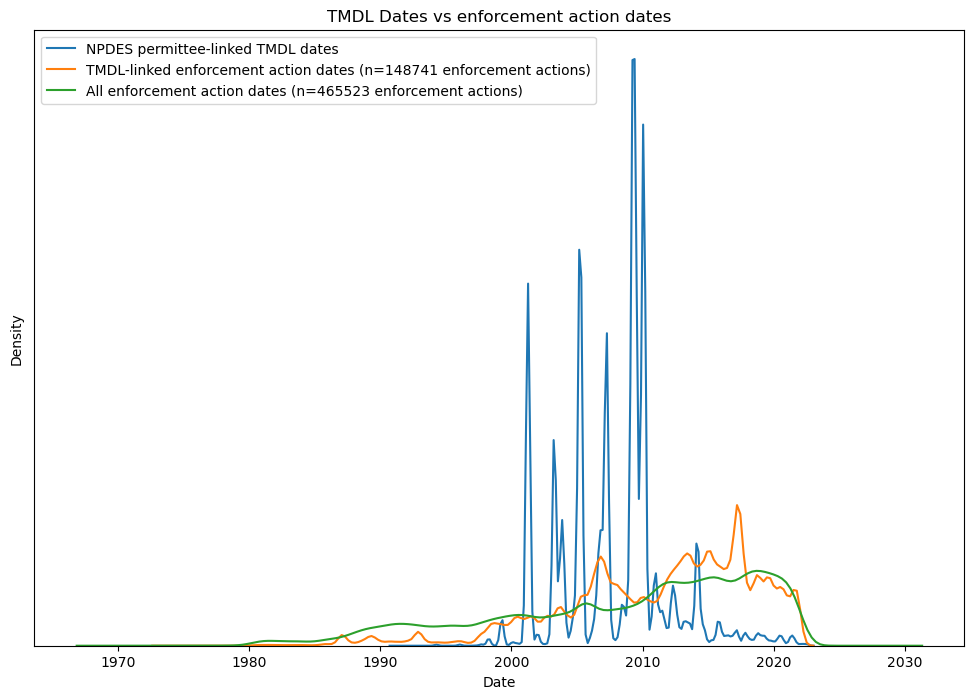

In [6]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.ylabel('Density')
plt.xlabel('Date')
plt.yticks([])
sns.kdeplot(data=tmdls_enforcements_merged, x='TMDLDate', label='NPDES permittee-linked TMDL dates');
sns.kdeplot(data=tmdls_enforcements_merged, x='enforcement_action_date', label='TMDL-linked enforcement action dates (n=' + str(len(tmdls_enforcements_merged.drop_duplicates('enf_identifier'))) + ' enforcement actions)');
sns.kdeplot(data=npdes_enforcement_actions, x='enforcement_action_date', label='All enforcement action dates (n=' + str(len(npdes_enforcement_actions.drop_duplicates('enf_identifier'))) + ' enforcement actions)');
plt.title('TMDL Dates vs enforcement action dates');
plt.legend();

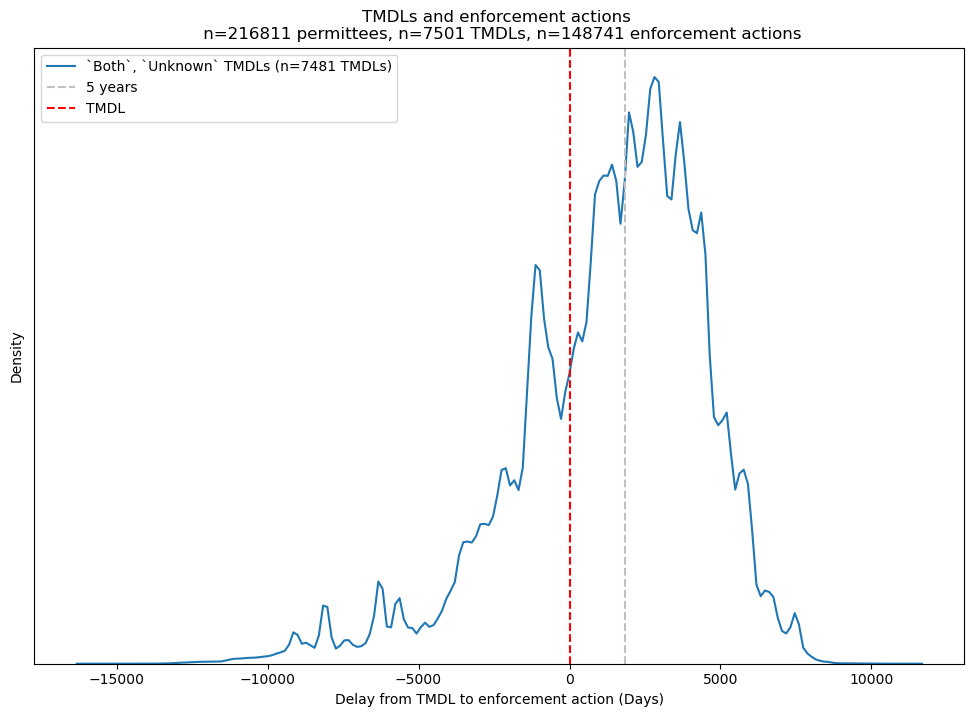

In [7]:
plt.style.use('default')
plt.figure(figsize=(12, 8));
plt.xlabel('Delay from TMDL to enforcement action (Days)')
sns.kdeplot(data=tmdls_enforcements_merged[tmdls_enforcements_merged['pollutantSourceTypeCode'] != 'Point source'], x='enforcement_action_delay', label='`Both`, `Unknown` TMDLs (n=' + str(len(tmdls_enforcements_merged[tmdls_enforcements_merged['pollutantSourceTypeCode'] != 'Point source'].drop_duplicates('actionIdentifier'))) + ' TMDLs)');
sns.kdeplot(data=tmdls_enforcements_merged[tmdls_enforcements_merged['pollutantSourceTypeCode']=='Point Source'], x='enforcement_action_delay', label='Point source TMDLs' + str(len(tmdls_enforcements_merged[tmdls_enforcements_merged['pollutantSourceTypeCode'] == 'Point source'].drop_duplicates('actionIdentifier'))));
plt.yticks([])
plt.axvline(x=365*5, linestyle='--', color='silver', label='5 years')
plt.axvline(x=0, linestyle='--', color='red', label='TMDL')
plt.title('TMDLs and enforcement actions \n n=' + str(
    len(tmdls_enforcements_merged.drop_duplicates('npdes_permit_id'))) + ' permittees, n=' + str(
    len(tmdls_enforcements_merged.drop_duplicates('actionIdentifier'))) + ' TMDLs, n=' + str(len(tmdls_enforcements_merged.drop_duplicates('enf_identifier'))) + ' enforcement actions');
plt.legend();